In [40]:
import os
import pandas as pd

from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import (
    GridSearchCV, RepeatedStratifiedKFold,
    StratifiedKFold, cross_val_score,
    train_test_split
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score,
                             make_scorer, precision_recall_curve,
                             precision_score, recall_score, matthews_corrcoef)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
current_directory = os.getcwd()
home_dir = current_directory.split("notebooks")[0]
data_dir = os.path.join(home_dir, "data")

In [3]:
os.getcwd()

'C:\\Users\\vnarv\\PycharmProjects\\wine_quality\\notebooks'

In [4]:
# read data
df_raw = pd.read_csv(os.path.join(data_dir, "wine-quality-white-and-red.csv"))

In [5]:
# drop perfect duplicates
df_dedup = df_raw.drop_duplicates()
# correct data types
df_dedup["quality"] = df_dedup["quality"].astype("category")
df_dedup["type"] = df_dedup["type"].astype("category")
# check nan
columns_with_nan = df_dedup.isna().any().any(axis=0)
if columns_with_nan:
    raise ValueError("Columns have NAN values")

C:\Users\vnarv\AppData\Local\Temp\ipykernel_16220\477210811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["quality"] = df_dedup["quality"].astype("category")
C:\Users\vnarv\AppData\Local\Temp\ipykernel_16220\477210811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["type"] = df_dedup["type"].astype("category")


In [6]:
target = "type"
df_x = df_dedup.drop(target, axis=1)
df_y = df_dedup[[target]]
df_y["y"] = np.where(df_dedup[target] == 'red', 1, 0)

C:\Users\vnarv\AppData\Local\Temp\ipykernel_16220\1279295188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y["y"] = np.where(df_dedup[target] == 'red', 1, 0)


In [7]:
X_train_, X_test, y_train_, y_test = train_test_split(
            df_x, df_y, test_size=0.2, stratify=df_y["y"], random_state=42
        )

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
            X_train_, y_train_, test_size=0.1, stratify=y_train_[target], random_state=42
        )

In [9]:
X_train.shape

(3830, 12)

In [10]:
y_train.shape

(3830, 2)

In [11]:
for df in [X_train, X_val, y_train, y_val, X_test, y_test]:
    print(df.shape)

(3830, 12)
(426, 12)
(3830, 2)
(426, 2)
(1064, 12)
(1064, 2)


In [12]:
from sklearn.preprocessing import OrdinalEncoder
def ordinal_encoder(Xtrain, Xval, Xtest, features):
    if features is None:
       features = Xtrain.select_dtypes("category").columns.tolist()
    # fit encoder
    enc = OrdinalEncoder()
    _ = enc.fit(Xtrain[features])
    # infer model
    for df in [Xtrain, Xval, Xtest]:
        print(df.shape)
        df[features]= enc.transform(df[features])
        print(df.shape)
    return Xtrain, Xval, Xtest
# scale data
from sklearn.preprocessing import StandardScaler
def scale_data(Xtrain, Xval, Xtest, features):
    if features is None:
        features = Xtrain.select_dtypes(np.number).columns.tolist()
    scaler = StandardScaler()
    scaler.fit(Xtrain)
    for df in [Xtrain, Xval, Xtest]:
        df[features]= scaler.transform(df[features])
    return Xtrain, Xval, Xtest
 

In [14]:
X_train, X_val, X_test = ordinal_encoder(X_train, X_val, X_test,None)
X_train, X_val, X_test = scale_data(X_train, X_val, X_test,None)  

(3830, 12)
(3830, 12)
(426, 12)
(426, 12)
(1064, 12)
(1064, 12)


In [15]:
X_train.shape

(3830, 12)

In [16]:
X_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [17]:
len(y_train)

3830

In [53]:
df_x.std()

C:\Users\vnarv\AppData\Local\Temp\ipykernel_16220\3435987344.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_x.std()


fixed acidity            1.319671
volatile acidity         0.168248
citric acid              0.147157
residual sugar           4.500180
chlorides                0.036863
free sulfur dioxide     17.805045
total sulfur dioxide    56.774223
density                  0.002966
pH                       0.160379
sulphates                0.149743
alcohol                  1.185933
dtype: float64

In [49]:
def get_models():
    seed = 42
    models = {
    "LogisticRegression":
    LogisticRegression(
        random_state=seed,
        #class_weight=cw_dict
    ),
    "SVM":
    SVC(
        #class_weight=cw_dict,
        probability=True
    ),
    "RandomForestClassifier":
        RandomForestClassifier(
            #class_weight=cw_dict,
            random_state=seed,
        ),
    "XGBClassifier":
        XGBClassifier(
            #use_label_encoder=False,
            eval_metric='logloss',
            random_state=seed,
        )
    }
    return models

def cross_validation(model, X, y, scoring):
    model_scores = []
    for score in scoring:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
        scores = cross_val_score(model, X, y, scoring=score, cv=cv, n_jobs=-1)
        model_scores.append(scores.mean())
    return model_scores

def predict_data(model,Xtrain, ytrain, X2, y2):
    model.fit(Xtrain, ytrain)
    return model.predict(X2)

In [43]:
mt_score = make_scorer(matthews_corrcoef)

In [47]:
y_train["y"].shape

(3830,)

LogisticRegression, mattew score: 98.3%, f1 macro 99.2%


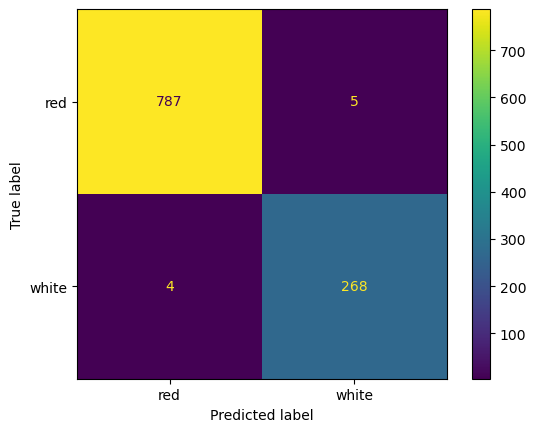

SVM, mattew score: 98.6%, f1 macro 99.3%


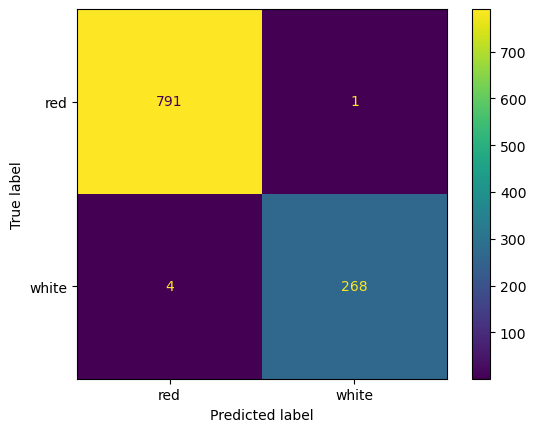

RandomForestClassifier, mattew score: 98.3%, f1 macro 99.1%


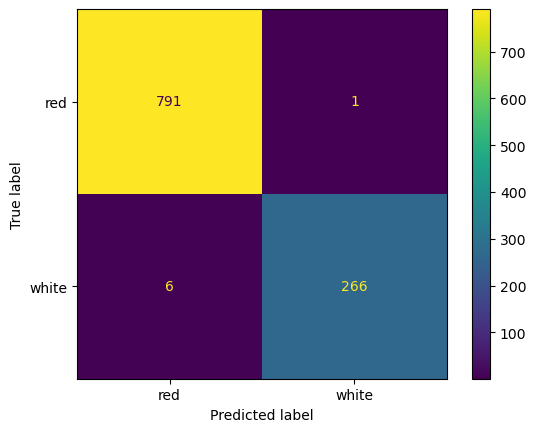

XGBClassifier, mattew score: 98.5%, f1 macro 99.2%


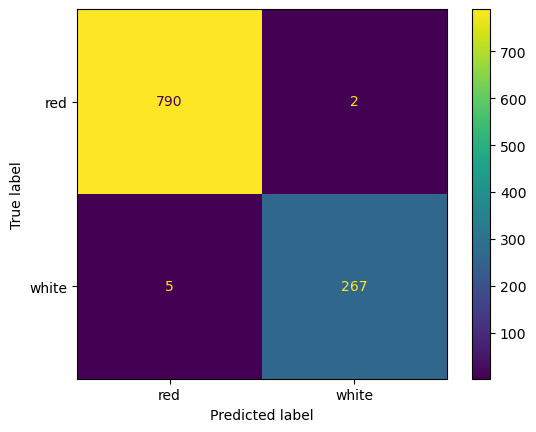

In [55]:
 import matplotlib.pyplot as plt
for name, m in get_models().items():
    scores = cross_validation(m, X_train, y_train["y"], [mt_score, "f1_macro"])
    print(f"{name}, mattew score: {scores[0]:.1%}, f1 macro {scores[1]:.1%}")
    y_test_pred = predict_data(m, X_train, y_train["y"], X_test, y_test["y"])
    cm = confusion_matrix(y_test["y"], y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["red", "white"])
    disp.plot()
    plt.show()